<a href="https://colab.research.google.com/github/aditya-shriwastava/colab-notebooks/blob/master/visual_odometry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# pip3 install

In [ ]:
!pip3 install scikit-image

# Download deer_robot dataset

In [1]:
!wget https://www.doc.ic.ac.uk/~wl208/lmdata/deer_robot.zip
!unzip  deer_robot.zip >/dev/null

--2021-12-27 04:09:32--  https://www.doc.ic.ac.uk/~wl208/lmdata/deer_robot.zip
Resolving www.doc.ic.ac.uk (www.doc.ic.ac.uk)... 146.169.13.6
Connecting to www.doc.ic.ac.uk (www.doc.ic.ac.uk)|146.169.13.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 615030528 (587M) [application/zip]
Saving to: ‘deer_robot.zip’

deer_robot.zip      100%[===================>] 586.54M  29.8MB/s    in 20s     

2021-12-27 04:09:54 (28.6 MB/s) - ‘deer_robot.zip’ saved [615030528/615030528]



# import

In [2]:
import os

import numpy as np

import cv2
from google.colab.patches import cv2_imshow

import matplotlib.pyplot as plt
%matplotlib inline

from skimage.measure import ransac

# deer_robot dataset utils

In [108]:
imgs_dir = "./deer_robot/cam0/data"
metadata_file = "./deer_robot/cam0/data.csv"
poses_gt_file = "./deer_robot/poses.gt"

calibration_matrix = np.array([
  [600, 0, 320],
  [0, 600, 240],
  [0,   0,   1]
], dtype=np.float)

def load_metadata():
  with open(metadata_file, 'r') as fd:
      metadata = fd.readlines()

  imgs_file = [
      line.split(',')[1][:-1] for line in metadata[1:]
  ]
  imgs_path = [os.path.join(imgs_dir, f) for f in imgs_file]
  timestamps = [float(line.split(',')[0])/1e9 for line in metadata[1:]]
  return imgs_path, timestamps

def load_poses_gt():
  with open(poses_gt_file, 'r') as fd:
    positions = []
    orientations = []
    for line in fd:
      if line[0] == '#':
        continue

      split = line.split(',')
      px = float(split[1])
      py = float(split[2])
      pz = float(split[3])
      p = [px, py, pz]
      positions.append(p)

      qw = float(split[4])
      qx = float(split[5])
      qy = float(split[6])
      qz = float(split[7])
      q = [qx, qy, qz, qw]
      orientations.append(q)
  return np.array(positions), np.array(orientations)

def load_batch(start, size):
  imgs_path, timestamps = load_metadata()
  imgs = np.array([
      cv2.imread(img_path) for img_path in imgs_path[start:start+size]
  ])
  p, q = load_poses_gt()
  return imgs, timestamps[start:start+size], p[start:start+size], q[start:start+size]

def load(index):
  imgs_path, timestamps = load_metadata()
  p, q = load_poses_gt()
  return cv2.imread(imgs_path[index]), timestamps[index], p[index], q[index]

# Features utils

In [109]:
class EssentialMatrixTransform():
  def __init__(self):
    pass

  def estimate(self, kps1, kps2):
    pass

  def residuals(self, kps1, kps2):
    pass

In [110]:
def extract_features(img):
  """
  Args
    img: numpy array of shape (H,W,C) representing image
  Returns
    kps: numpy array of shape (N, 2) representing coordinates of N
      keypoints detected
    des: numpy array of shape (N, 32) representing 32 dim descriptor
      of N keypoints
  """
  img = np.expand_dims(np.mean(img, axis=2).astype(np.uint8), -1)
  orb = cv2.ORB_create(nfeatures=1000)
  kps, des = orb.detectAndCompute(img, None)
  kps = np.array([[kp.pt[0], kp.pt[1]] for kp in kps]).astype(np.int32)
  return kps, des

def match_features(des1, des2):
  bf_matcher = cv2.BFMatcher(cv2.NORM_HAMMING)
  matches = bf_matcher.knnMatch(des1, des2, k=2)

  idx1, idx2 = [], []
  for m1, m2 in matches:
    # Lowe's ratio test
    if m1.distance < 0.75 * m2.distance:
      if m1.distance < 32:
        if m1.trainIdx not in idx2:
          idx1.append(m1.queryIdx)
          idx2.append(m1.trainIdx)

  assert len(idx1) >= 5
  return np.array([idx1, idx2]).T

def estimate_essential_matrix(kps1, kps2, matches):
  kps1 = kps1[matches[:,0]]
  kps2 = kps2[matches[:,1]]

  essential_matrix, inliers = ransac(
    (kps1, kps2),
    EssentialMatrixTransform,
    min_samples=5,
    residual_threshold=0.02,
    max_trials=100)

# Main

#kps_t: 266, #kps_tn1: 324
#matches: 117


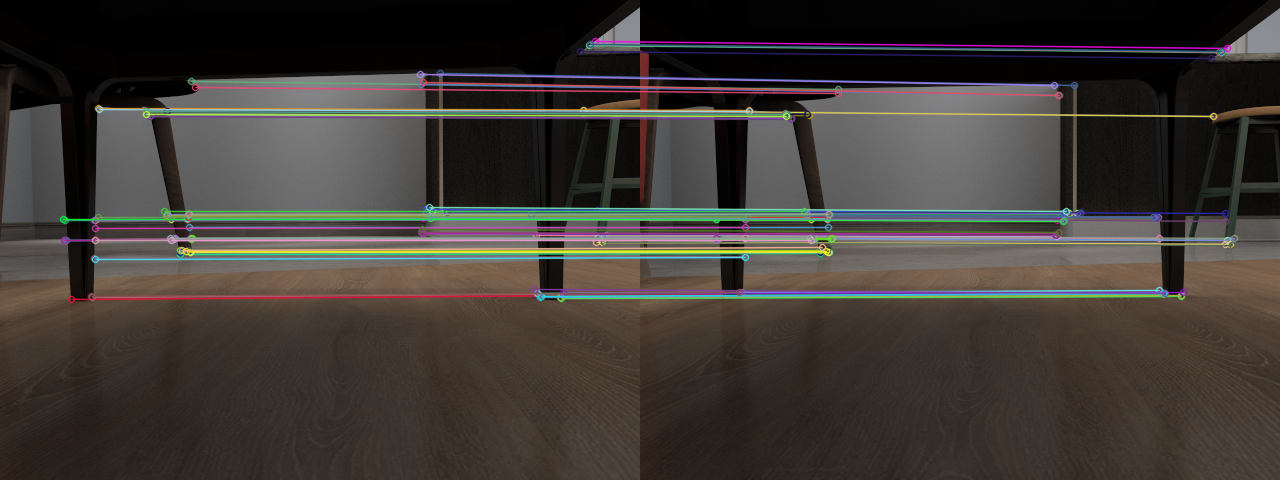

In [113]:
tn1 = 0
t = 10
img_tn1 = load(tn1)[0]
img_t = load(t)[0]

kps_tn1, des_tn1 = extract_features(img_tn1)
kps_t, des_t = extract_features(img_t)
print(f"#kps_t: {len(kps_t)}, #kps_tn1: {len(kps_tn1)}")

matches = match_features(des_t, des_tn1)
print(f"#matches: {len(matches)}")

img_match = cv2.drawMatches(
    img_t, [cv2.KeyPoint(kp_t[0], kp_t[1], 0) for kp_t in kps_t],
    img_tn1, [cv2.KeyPoint(kp_tn1[0], kp_tn1[1], 0) for kp_tn1 in kps_tn1],
    [cv2.DMatch(match[0], match[1], 0) for match in matches],
    None,
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
)
cv2_imshow(img_match)

# matches = estimate_essential_matrix(kps_t, kps_tn1, matches)

# Play with RANSAC from scikit-learn

In [5]:
!pip3 install scikit-image

In [6]:
from skimage.measure import ransac
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [20]:
class Line2D():
  def __init__(self):
    # 2d line is modeled as y = ax + b
    self.a = 0.0
    self.b = 0.0

  def estimate(self, data):
    """
    Args:
      data: numpy array of shape (N,2)
    Returns:
      True or False based on whether model was estimated successfully.
    """
    N = len(data)
    assert N >= 2, "Under determined system!"

    A = np.vstack((
      data[:,0],
      np.ones(N)
    )).T
    b = data[:,1]
    try:
      self.a, self.b = np.linalg.inv(A.T @ A) @ A.T @ b
      return True
    except np.linalg.LinAlgError:
      return False

  def residuals(self, data):
    """
    Args:
      data: numpy array of shape (N,2)
    Returns:
      numpy array of shape (N,) representing the residue for each data point
    """
    return (self.a * data[:,0] - data[:,1] + self.b)**2 / (self.a**2 + 1)
  
  def predict_y(self, x):
    return self.a * x + self.b

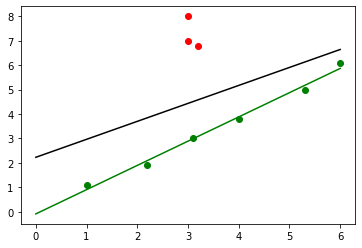

In [22]:
inlier = np.array([[1,1.1],[2.2,1.9],[3.1,3],[4,3.8],[5.3,5], [6,6.1]])
outlier = np.array([[3,7],[3.2,6.8],[3,8]])
data = np.vstack((inlier, outlier))
plt.scatter(inlier[:,0], inlier[:,1], color='green')
plt.scatter(outlier[:,0], outlier[:,1], color='red')

model = Line2D()
model.estimate(data)

plt.plot(np.arange(7), model.predict_y(np.arange(7)), color='black')

model_robust, inlier_est = ransac(
  data,
  Line2D,
  min_samples=2,
  residual_threshold=0.4,
  max_trials=100
)

plt.plot(np.arange(7), model_robust.predict_y(np.arange(7)), color='green')

# Docs

## Track Progress

### Day 1
#### TODO
- Understand ORB feature detector.
    (image) --|ORB|--> keypoints & descriptor
#### Done
ORB: (Oriented FAST) + (Rotated BRIEF)

- Understood how FAST and BRIEF works
- Understood modification of FAST in ORB
- Used ORB from cv2 to detect and display keypoints and Understood the mapping
  between input and output to ORB.

### Day 2
#### TODO
- Understand the ORB descriptor given the keypoint.
- And verify it with the cv2 ORB implementation.
- Feature matching, RENSAC and vo with ORB.
#### Done
- Understood ORB detector and descriptor and verified it with cv2 implementation.
- Understood brute force feature matchinga and verified with cv2.

### Day 3
#### TODO
- Read Tutorial 1:
    - Formulation of the VO Problem
    - Camera Modeling and Calibration
    - Motion Estimation
#### Done
- Understood Formulation of the VO Problem, Camera Modeling and Calibration.
- Stuck at Motion Estimation (What is Fundamental and Essential Matrices?)

### Day 4
#### TODO
- Understand Essential and Fundamental Matrices.
- Read DF-VO: What Should Be Learnt for Visual Odometry?

#### Done
- Understood Essential and Fundamental Matrices.
- Read DF-VO Introduction

### Day 5
#### TODO
- Read about ORB SLAM.

### Some Day
- Use RANSAC to obtain corrospending ORB features in image pair.
- Use corrospending ORB features in image pair and calibration matrix to obtain essential matrix.

## README

### Visual Odometry

(Camera data stream) --|Visual Odometry|--> (Camera Pose over time)

**Approach:** ORB Feature based Monocular Visual Odometry

**Dataset:** [ICL Dataset](https://peringlab.org/lmdata/)

#### Reference
1. [geohotz twitchslam](https://github.com/geohot/twitchslam)
2. [ORB: An efficient alternative to SIFT or SURF](https://github.com/commaai/rednos://ieeexplore.ieee.org/abstract/document/6126544)
3. [Introduction to ORB (Oriented FAST and Rotated BRIEF): Medium Post](https://medium.com/data-breach/introduction-to-orb-oriented-fast-and-rotated-brief-4220e8ec40cf)
4. [SVO: Fast Semi-Direct Monocular Visual Odometry](https://www.zora.uzh.ch/id/eprint/125453/1/ICRA14_Forster.pdf)
5. Visual Odometry Tutorial
    2. [Visual Odometry (Part 1): The First 30 Years and Fundamentals](https://www.alaakhamis.org/teaching/SPC418/reading/Visual%20odometry.pdf)
    3. [Visual Odometry (Part 2): Matching, Robustness, Optimization, and Applications](https://www.zora.uzh.ch/id/eprint/71030/1/Fraundorfer_Scaramuzza_Visual_odometry.pdf)